#Importing the images:
Style image as 'Starry Night' by Van Gogh

Base image for content

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")#base image to put the art to.
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")#artistic image

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 0s 0us/step


#Preprocessing the images:
Preprocessing using the vgg 19 algorithm as the input is given to that model.

Function to preprocess an image before using it in a neural network

In [2]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

#Using the pre-trained model VGG19:

In [3]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


#Defining the loss:

In [4]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [5]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
# These are weights that balance the contributions of the total
# variation loss, style loss, and content loss to the final combined loss.
# They determine the importance of each aspect in the generated image.
total_variation_weight = 1.5e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

#Training using the Loss Functions:

Taking 500 iteration to set up the weights


In [6]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 500
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"{i}th Iteration Loss: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

100th Iteration Loss: loss=9892.01
200th Iteration Loss: loss=8286.46
300th Iteration Loss: loss=7647.06
400th Iteration Loss: loss=7289.72
500th Iteration Loss: loss=7055.50


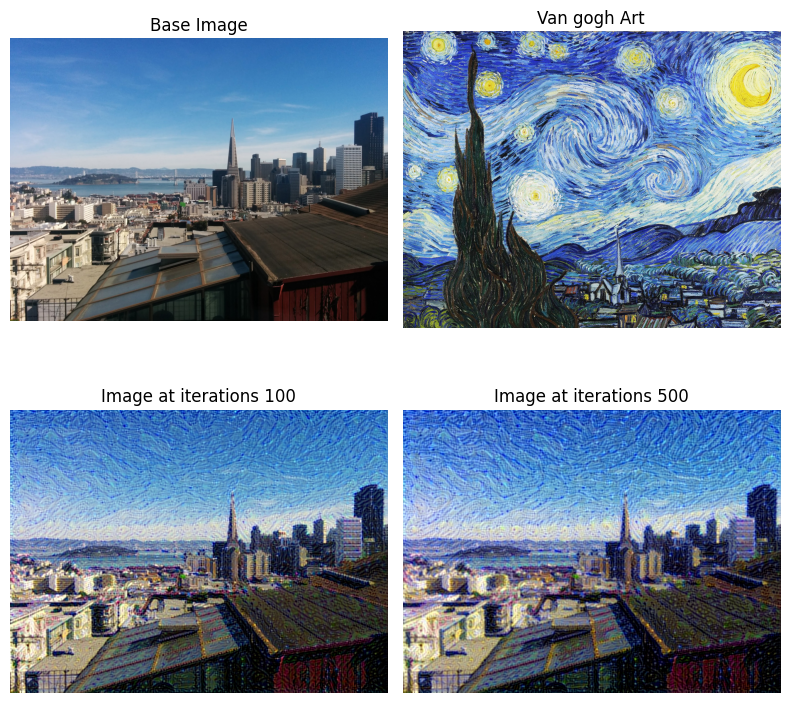

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def plot_images(image_paths):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Creating a 2x2 grid for images
    axs = axs.ravel()

    for i, path in enumerate(image_paths):
        if i == 0:
            img = plt.imread(base_image_path)
            axs[i].imshow(img)  # Display image in the corresponding subplot
            axs[i].set_title("Base Image")
            axs[i].axis('off')
        elif i == 1:
            img = plt.imread(style_reference_image_path)
            axs[i].imshow(img)  # Display image in the corresponding subplot
            axs[i].set_title("Van gogh Art")
            axs[i].axis('off')
        elif i == 2:
            img = mpimg.imread(path)  # Read image using the image path
            axs[i].imshow(img)  # Display image in the corresponding subplot
            axs[i].set_title("Image at iterations 100")
            axs[i].axis('off')  # Hide the axes for better visualization
        else:
            img = mpimg.imread(path)  # Read image using the image path
            axs[i].imshow(img)  # Display image in the corresponding subplot
            axs[i].set_title("Image at iterations 500")
            axs[i].axis('off')  # Hide the axes for better visualization


    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Example usage:
image_paths = [
    'https://img-datasets.s3.amazonaws.com/sf.jpg',
    'https://img-datasets.s3.amazonaws.com/starry_night.jpg',
    '/content/combination_image_at_iteration_100.png',
    '/content/combination_image_at_iteration_500.png'
]

plot_images(image_paths)